In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')

In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering,\
box_clustering, adaptive_box2, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths,\
confusion_matrix



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend

In [7]:
pd.set_option("display.max_columns", None)

### Directory to save figures

In [8]:
save = True
path_figs = './figs/20K/'
Path(path_figs).mkdir(exist_ok = True, parents = True)

### Generate Experiment

In [9]:
%%time

N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 83.2 ms, sys: 18.8 ms, total: 102 ms
Wall time: 96.2 ms


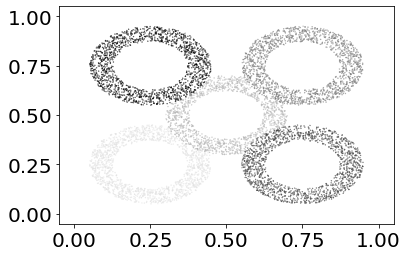

In [10]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

 ### Estimate ITE with Gradient Boosting Trees

In [11]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 26.9 s, sys: 93.5 ms, total: 27 s
Wall time: 27 s


### Apply box clustering to use for the adaptive algorithm

In [12]:
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

### Calculate ATT per box cluster for optimal clustering

In [13]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

### Optimal 1d means recover

In [14]:
name2 = 'Box-ATT'
name = 'Opt-Clust'
val = 6
box2, means = optimal_clustering(box2, max_clusters = 7, col_select = name2, 
                      cluster_name = name, N=N, val = val )

Did not pick 6, it picked: 3


In [15]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster
0,0.548814,0.715189,0,0,1.818695,0.331995,-1.486700,0,2.902260,1.083565,83
1,0.602763,0.544883,0,0,-4.484119,4.071923,8.556041,0,-2.841781,1.642338,61
2,0.423655,0.645894,2,0,2.067594,-3.595953,-5.663548,0,3.069443,1.001849,81


### Adaptive Box

In [16]:
%%time
adaptive_ite_name = 'ITE-ADAPTIVE'
ite_old_name = 'ITE-GDBR'
data = adaptive_box2(data, clusters = clusters, ite_old_name = ite_old_name,
                    ite_name = adaptive_ite_name, col_select = col_select)

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data_groups2' of function 'adapt_numba'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../src/clustering_algos.py", line 478:
@jit(nopython = True)
def adapt_numba(data_groups2, new_ites, values, pivot_array,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


CPU times: user 10 s, sys: 19 ms, total: 10 s
Wall time: 10 s


In [17]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-ADAPTIVE
0,0.548814,0.715189,0,0,1.818695,0.331995,-1.486700,0,2.902260,1.083565,83,1.821672
1,0.602763,0.544883,0,0,-4.484119,4.071923,8.556041,0,-2.841781,1.642338,61,1.044648
2,0.423655,0.645894,2,0,2.067594,-3.595953,-5.663548,0,3.069443,1.001849,81,2.451187


In [18]:
clusts = len(means)
means2 = means.reshape(val,1)

data, km = kmeans_clustering(data, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                           col_select = [adaptive_ite_name], assign_means = True, means = means2 )

In [19]:
print(means2)
print(km.cluster_centers_)

[[-0.29486468]
 [ 0.25339289]
 [ 1.00218139]
 [ 1.67418808]
 [ 2.69616256]
 [ 4.02468922]]
[[-0.29486468]
 [ 0.25339289]
 [ 1.00218139]
 [ 1.67418808]
 [ 2.69616256]
 [ 4.02468922]]


### Adaptive ITES values scatter plot

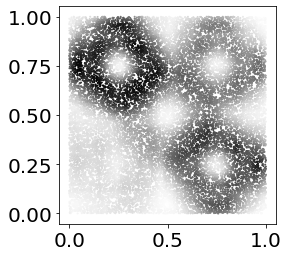

In [20]:
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)

fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data[adaptive_ite_name], cmap = 'Greys', s = 1)
if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path3+'{}.jpeg'.format('ites'), bbox_inches='tight',pad_inches = 0)

###  Clustering of Adaptive ites

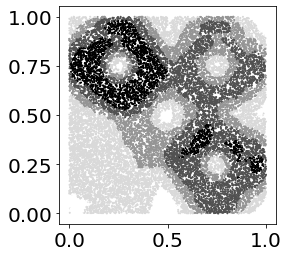

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-ADAPTIVE-3CLUST'], cmap = 'Greys', s = 1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path3+'{}.jpeg'.format('ITE-ADAPTIVE-3CLUST'), bbox_inches='tight',pad_inches = 0)

### Histogram of Adaptive Ites

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


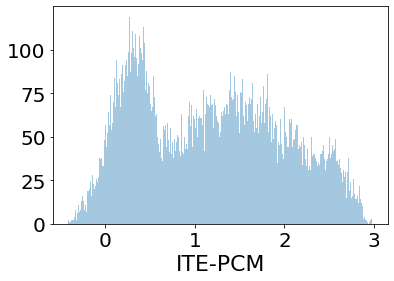

In [22]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

fig, ax = plt.subplots()

ax = sns.distplot(data[adaptive_ite_name],  bins=400, kde = False,ax = ax)
ax.set_xlabel('ITE-PCM')
#ax.set_xlim(-2,2)
if save:
    fig.savefig(path2+'adaptivehist.pdf', bbox_inches='tight',pad_inches = 0)


In [23]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [24]:
#ite_column = 'ITE-GDBR'
ite_column = 'ITE-GDBR'
clust2 = 'ITE-ADAPTIVE-3CLUST'
data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [25]:
ite_column = 'ITE'

data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [26]:
errors = data.describe().loc[['mean', 'std'], [col for col in data.columns if 'err' in col]].T

In [27]:
errors.sort_values(by = 'mean')

,mean,std
ITE-ADAPTIVE-3CLUST-err-GDBR,1.023393,0.899856
ITE-ADAPTIVE-3CLUST-err-True-ITE,1.028733,0.894130


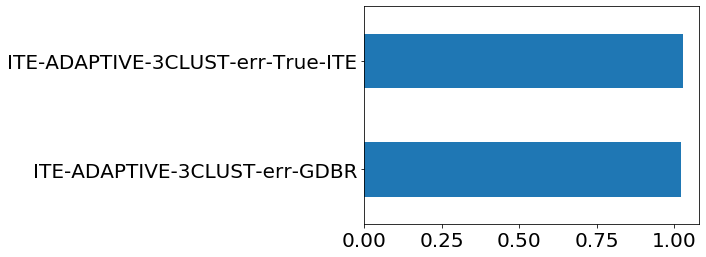

In [28]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [29]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)

mat = confusion_matrix(data, 'C', 'ITE-ADAPTIVE-3CLUST', 6, save = save, save_dir = path4)
display(mat)

,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.056772,0.375039,0.281654,0.223543,0.062992,0.0
C1 True,0.000000,0.812197,0.187803,0.000000,0.000000,0.0
C2 True,0.000000,0.000000,0.389465,0.545769,0.064767,0.0
C3 True,0.000000,0.000000,0.205294,0.794706,0.000000,0.0
C4 True,0.000000,0.000000,0.019342,0.753707,0.226950,0.0
C5 True,0.000000,0.000000,0.000000,0.128205,0.871795,0.0


In [30]:
data.groupby('ITE-ADAPTIVE-3CLUST').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-ADAPTIVE,ITE-ADAPTIVE-3CLUST-err-GDBR,ITE-ADAPTIVE-3CLUST-err-True-ITE
ITE-ADAPTIVE-3CLUST,,,,,,,,,,,,,,
0,0.535687,0.317071,0.000000,0.481276,1.026085,0.922458,-0.270290,0.220527,1.016087,-0.161171,38.660194,-0.140427,0.161171,0.270290
1,0.365431,0.371200,0.197473,0.495029,0.829724,0.913432,0.122782,0.196967,0.819791,0.123265,42.996967,0.306285,0.272055,0.271762
2,0.578359,0.559074,0.483538,0.499677,1.020475,1.046230,0.498014,0.205509,1.002634,0.497383,67.944911,1.008727,0.751870,0.752210
3,0.617988,0.529594,1.754115,0.513989,1.367723,1.314830,1.774608,0.196511,1.323629,1.754187,64.935155,1.730136,1.639209,1.637871
4,0.345637,0.669693,3.253720,0.506677,2.011163,1.934623,3.339111,0.199542,1.902925,3.380896,78.888211,2.486479,2.015734,2.029620
